In [3]:
# How to handle Imbalanced Data in machine learning classification
# The slides presented are based on the following Tutorial
# https://www.justintodata.com/imbalanced-data-machine-learning-classification/
# This tutorial will focus on imbalanced data in machine learning for binary classes,
# but you could extend the concept to multi-class. 
!pip install imblearn #install imblearn if not installed before

import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

In [4]:
# Read the dataset
df = pd.read_csv('abalone19.dat')
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,negative
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,negative
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,negative
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,negative
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,negative


In [5]:
# Find out more about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4174 non-null   object 
 1   Length          4174 non-null   float64
 2   Diameter        4174 non-null   float64
 3   Height          4174 non-null   float64
 4   Whole_weight    4174 non-null   float64
 5   Shucked_weight  4174 non-null   float64
 6   Viscera_weight  4174 non-null   float64
 7   Shell_weight    4174 non-null   float64
 8   Class           4174 non-null   object 
dtypes: float64(7), object(2)
memory usage: 293.6+ KB


In [6]:
# Produce some stats on the dataset
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000
mean,0.524032,0.407919,0.139524,0.828771,0.359361,0.180607,0.238853
std,0.120033,0.099187,0.041818,0.490065,0.221771,0.109574,0.139143
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.442125,0.186500,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799750,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.501875,0.252875,0.328875
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [7]:
# We’ll use the most basic machine learning classification algorithm: logistic regression. 
# It is better to convert all the categorical columns for logistic regression to dummy variables. 
# we’ll convert the categorical columns (Sex and Class) within the dataset before modeling.
# Lets look at the category of Sex
# Three Classes: Male, Infant and Female

df['Sex'].value_counts()

Sex
M    1526
I    1341
F    1307
Name: count, dtype: int64

In [8]:
# Lets look at the category of Class
# Two Classes: Negative and Positive
df['Class'].value_counts()

Class
negative    4142
positive      32
Name: count, dtype: int64

In [9]:
# Let us convert the Class label into 0 and 1
df['Class'] = df['Class'].map(lambda x: 0 if x == 'negative' else 1)
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0
...,...,...,...,...,...,...,...,...,...
4169,M,0.560,0.430,0.155,0.8675,0.4000,0.1720,0.2290,0
4170,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,0
4171,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0
4172,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0


In [10]:
# Let us convert the Sex feature into two dummy variables
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Class,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,0,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,True,False
...,...,...,...,...,...,...,...,...,...,...
4169,0.560,0.430,0.155,0.8675,0.4000,0.1720,0.2290,0,False,True
4170,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,0,False,False
4171,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,False,True
4172,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,False,True


In [11]:
df['Class'].value_counts(normalize=True)

Class
0    0.992333
1    0.007667
Name: proportion, dtype: float64

<Axes: xlabel='Class'>

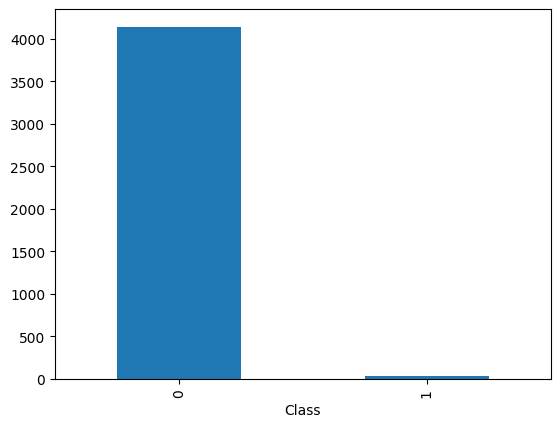

In [12]:
df['Class'].value_counts().plot(kind='bar')

In [13]:
# Splitting Training and Testing sets
# Let’s split the dataset into training (80%) and test sets (20%). 
# Use the train_test_split function with stratify argument based on Class categories. 
# So that both the training and test datasets will have similar portions of classes as # the complete dataset. 
# This is important for imbalanced data.

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Class'], random_state=888)

features = df_train.drop(columns=['Class']).columns

In [14]:
# Two sets: df_train and df_test. 
# We’ll use df_train for modeling, and df_test for evaluation.
# Print the different classes (0 and 1) that are present in the Training Set
df_train['Class'].value_counts()

Class
0    3313
1      26
Name: count, dtype: int64

In [15]:
# Print the different classes (0 and 1) that are present in the Testing Set
df_test['Class'].value_counts()

Class
0    829
1      6
Name: count, dtype: int64

In [16]:
# Let us train a Logistic Regression with the unbalanced Data and check the auc
clf = LogisticRegression(random_state=888)

features = df_train.drop(columns=['Class']).columns
clf.fit(df_train[features], df_train['Class'])

y_pred = clf.predict_proba(df_test[features])[:, 1]

print("The AUC score for this model using the original unbalanced data ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score for this model using the original unbalanced data ...


np.float64(0.6831523924406916)

In [17]:
# we could use the library imbalanced-learn to random oversample.

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

ros = RandomOverSampler(random_state=888)
X_resampled, y_resampled = ros.fit_resample(df_train[features], df_train['Class'])
y_resampled.value_counts()

Class
0    3313
1    3313
Name: count, dtype: int64

In [18]:
# We can then apply Logistic Regression and calculate the AUC metric.
clf = LogisticRegression(random_state=888)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict_proba(df_test[features])[:, 1]

print("The AUC score for this model after Random Over Sampling  ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score for this model after Random Over Sampling  ...


np.float64(0.8389626055488542)

In [19]:
# Random sampling is easy, but the new samples don’t add more information. 
# SMOTE improves on that. 
# SMOTE oversamples the minority class by creating ‘synthetic’ examples.
# It involves some methods (nearest neighbors), to generate plausible examples.
print("Oversampling using SMOTE ...")
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=888)
X_resampled, y_resampled = smote.fit_resample(df_train[features], df_train['Class'])

y_resampled.value_counts()

Oversampling using SMOTE ...


Class
0    3313
1    3313
Name: count, dtype: int64

In [21]:
# We’ll apply logistic regression on the balanced dataset and calculate its AUC.

clf = LogisticRegression(random_state=888)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict_proba(df_test[features])[:, 1]
print("The AUC score for this model after SMOTE ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score for this model after SMOTE ...


np.float64(0.8564535585042219)

In [22]:
# Now we will use Undersampling
# Undersampling, we will downsize majority class to balance with the minority class.
# Simple random undersampling
# We’ll begin with simple random undersampling. 
rus = RandomUnderSampler(random_state=888)
X_resampled, y_resampled = rus.fit_resample(df_train[features], df_train['Class'])

y_resampled.value_counts()

Class
0    26
1    26
Name: count, dtype: int64

In [23]:
# And this produces the same AUC as pandas undersampling, since we use the same
clf = LogisticRegression(random_state=888)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict_proba(df_test[features])[:, 1]
print("The AUC score for this model after Under Sampling ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score for this model after Under Sampling ...


np.float64(0.6467631684760756)

In [24]:
# Undersampling using K-Means
# Besides random sampling, we could also use the cluster centroid of 
# the K-Means method as the new sample of the majority class. 

cc = ClusterCentroids(random_state=888)
X_resampled, y_resampled = cc.fit_resample(df_train[features], df_train['Class'])

y_resampled.value_counts()

Class
0    26
1    26
Name: count, dtype: int64

In [25]:
# Use Logistic Regression on the new dataset that is undersampled using K-Means
clf = LogisticRegression(random_state=888)

clf.fit(X_resampled, y_resampled)
y_pred = clf.predict_proba(df_test[features])[:, 1]

print("The AUC score for this model after using K-Means ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score for this model after using K-Means ...


np.float64(0.732810615199035)

In [26]:
# Weighing classes differently
# We can also balance the classes by weighing the data differently
# We usually consider each observation equally, with a weight value of 1
# But for imbalanced datasets, we can balance the classes by putting more weight   # on the minority classes.
# The below code estimates weights for our imbalanced training dataset.

weights = compute_class_weight('balanced', classes=df_train['Class'].unique(), y=df_train['Class'])
print("If we want the dataset to be balanced, we need the following weights for Majority vs Minority ..")
weights

If we want the dataset to be balanced, we need the following weights for Majority vs Minority ..


array([ 0.50392394, 64.21153846])

In [27]:
# Let’s verify that these weights can indeed balance the dataset.
# Multiply the counts of each class by their respective weights.

print("Performing the following re-wieghting of classes we get ..")
print((df_train['Class'] == 0).sum()*weights[0])
print((df_train['Class'] == 1).sum()*weights[1])

Performing the following re-wieghting of classes we get ..
1669.5
1669.5000000000002


In [28]:
# If we sum up the weights of both classes,
# it is equivalent to if we just weight each data by 1.
print((df_train['Class'] == 0).sum()*weights[0] + (df_train['Class'] == 1).sum()*weights[1])
print((df_train['Class'] == 0).sum() + (df_train['Class'] == 1).sum())

3339.0
3339


In [29]:
# All right! So now you’ve got the idea of how to weigh classes differently.
# What does this mean for a machine learning algorithm like logistic regression?
# Different weights make it cost more to misclassify a minority than majority class
# We can use code below to apply LR to the differently weighted datasets,
# with the extra argument class_weight='balanced’.

clf_weighted = LogisticRegression(class_weight='balanced', random_state=888)
clf_weighted.fit(df_train[features], df_train['Class'])

y_pred = clf_weighted.predict_proba(df_test[features])[:, 1]

print("The AUC score after using Weighted Logistic Regression (balanced) ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score after using Weighted Logistic Regression (balanced) ...


np.float64(0.8260956976276639)

In [30]:
# Besides changing the weights of the two classes to balance them, 
# We can also specify custom weights of positive and negative classes
# For example, the below code weighs class 1 by 100 times more than class 0.

clf_weighted = LogisticRegression(class_weight={0: 1, 1: 100}, random_state=888)

clf_weighted.fit(df_train[features], df_train['Class'])
y_pred = clf_weighted.predict_proba(df_test[features])[:, 1]

print("The AUC score after using Weighted Logistic Regresion (weighted) ...")
roc_auc_score(df_test['Class'], y_pred)

The AUC score after using Weighted Logistic Regresion (weighted) ...


np.float64(0.8373542420587052)